The coding Implementation of 100x, 50x and 10x on 0.1 and 0.01 Learning Rate are all the same

I have provided the code for 0.1 Learning rate Models for 100x, 50x and 10x Dataset Model


I have done inference threshold search for each model after their training, in order to get the inference threshold value that yields the highest accuracy

ELF Model:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        return self.relu(x)

class ResNet32_ELF(nn.Module):
    def __init__(self, block, layers, image_channels=3, num_classes=10):
        super(ResNet32_ELF, self).__init__()
        self.in_channels = 16

        # First conv layer (CIFAR version: smaller kernel, no maxpool)
        self.conv1 = nn.Conv2d(image_channels, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()

        # Residual block groups
        self.layer1 = self.make_layers(block, layers[0], out_channels=16, stride=1)
        self.layer2 = self.make_layers(block, layers[1], out_channels=32, stride=2)
        self.layer3 = self.make_layers(block, layers[2], out_channels=64, stride=2)

        # Exits after each block group
        self.exit1 = self._make_exit(16, num_classes)
        self.exit2 = self._make_exit(16, num_classes)
        self.exit3 = self._make_exit(32, num_classes)

        # Final output after last block group
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def _make_exit(self, in_channels, num_classes):
        return nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(64, num_classes)
        )

    def make_layers(self, block, num_blocks, out_channels, stride):
        identity_downsample = None
        if stride != 1 or self.in_channels != out_channels:
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        layers = [block(self.in_channels, out_channels, identity_downsample, stride)]
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x, exit_threshold=None, is_training=True):
        outputs, confidences = [], []

        x = self.relu(self.bn1(self.conv1(x)))
        #Exit1
        out1 = self.exit1(x)
        outputs.append(out1)
        confidences.append(torch.max(F.softmax(out1, dim=1), dim=1)[0])

        x = self.layer1(x)
        #Exit2
        out2 = self.exit2(x)
        outputs.append(out2)
        confidences.append(torch.max(F.softmax(out2, dim=1), dim=1)[0])

        x = self.layer2(x)
        #Exit3
        out3 = self.exit3(x)
        outputs.append(out3)
        confidences.append(torch.max(F.softmax(out3, dim=1), dim=1)[0])

        x = self.layer3(x)
        #exit4
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        out_final = self.fc(x)
        outputs.append(out_final)
        confidences.append(torch.max(F.softmax(out_final, dim=1), dim=1)[0])

        if is_training or exit_threshold is None:
            return outputs, confidences
        else:
            for out, conf in zip(outputs, confidences):
                if (conf > exit_threshold).all():
                    return out
            return outputs[-1]

def ResNet32_ELF_model(img_channels=3, num_classes=10):
    return ResNet32_ELF(block, [5, 5, 5], img_channels, num_classes)

net= ResNet32_ELF_model()
net

ResNet32_ELF(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    

Dataset Loading

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

def get_cifar10_lt_32x32_loaders(batch_size=128, imbalance_ratio=100, root='./data'):

    mu = 1 / imbalance_ratio
    num_classes = 10
    max_per_class = 5000

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    full_train = datasets.CIFAR10(root=root, train=True, download=True, transform=transform_train)
    targets = np.array(full_train.targets)

    # Create long-tailed distribution
    class_counts = [int(max_per_class * mu ** (i / (num_classes - 1))) for i in range(num_classes)]

    selected_indices = []
    for cls, count in enumerate(class_counts):
        cls_indices = np.where(targets == cls)[0]
        selected = np.random.choice(cls_indices, count, replace=False)
        selected_indices.extend(selected)

    # Create long-tailed training subset
    train_lt_dataset = Subset(full_train, selected_indices)
    train_loader = DataLoader(train_lt_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

    test_dataset = datasets.CIFAR10(root=root, train=False, download=True, transform=transform_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, test_loader, class_counts

train_loader, test_loader, class_counts = get_cifar10_lt_32x32_loaders(imbalance_ratio=10)
print("Training class distribution:", class_counts)

100%|██████████| 170M/170M [00:03<00:00, 48.8MB/s]


Training class distribution: [5000, 3871, 2997, 2320, 1796, 1391, 1077, 834, 645, 500]


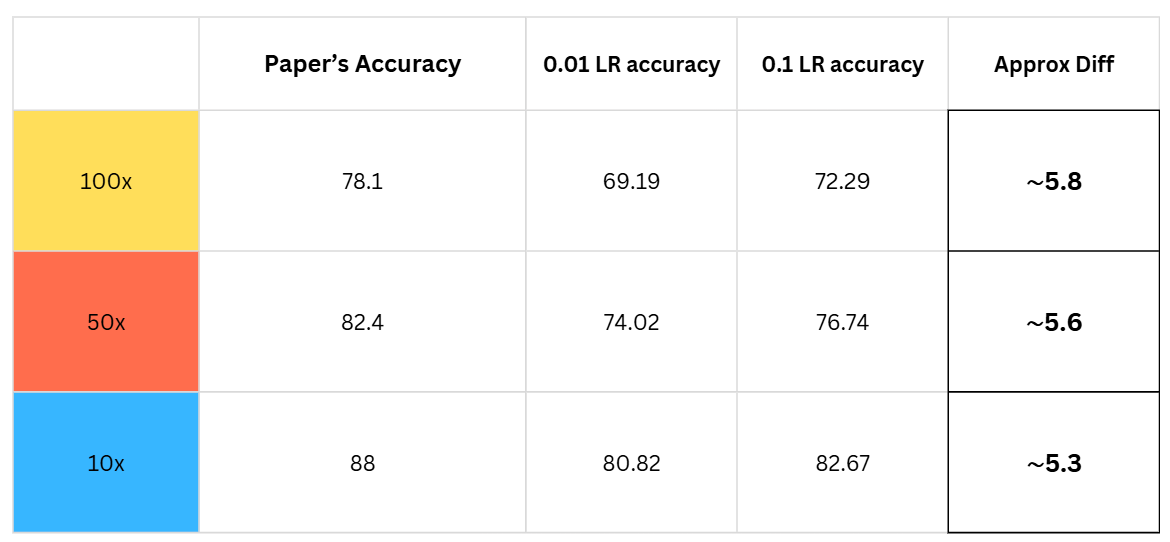

## 100x

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import time


# ================== LDAM Loss (with per-sample reduction) ==================
class LDAMLoss(nn.Module):
    def __init__(self, class_counts, max_m=0.5, weight=None, s=30):
        super(LDAMLoss, self).__init__()
        margins = 1.0 / np.power(class_counts, 0.25)
        self.margins = torch.tensor(margins * (max_m / np.max(margins)), dtype=torch.float)
        self.weight = weight
        self.s = s

    def forward(self, logits, labels):
        if logits.device != self.margins.device:
            self.margins = self.margins.to(logits.device)
        if self.weight is not None and self.weight.device != logits.device:
            self.weight = self.weight.to(logits.device)

        index = torch.zeros_like(logits, dtype=torch.bool)
        index.scatter_(1, labels.data.view(-1, 1), 1)

        margin_adjusted_logits = logits - self.margins[labels].unsqueeze(1) * index.float()
        return F.cross_entropy(self.s * margin_adjusted_logits, labels, weight=self.weight, reduction='none')

# ================== DRW (Delayed Reweighting) ==================
def get_drw_weights(epoch, class_counts, drw_start_epoch, beta=0.9999):
    if epoch < drw_start_epoch:
        return None

    effective_num = 1.0 - np.power(beta, class_counts)
    weights = (1.0 - beta) / effective_num
    weights = weights / np.sum(weights) * len(class_counts)
    return torch.tensor(weights, dtype=torch.float)

# ================== ELF Loss Aggregation (Corrected Logic) ==================
def compute_elf_loss_per_batch(outputs, labels, criterion, threshold):
    batch_size = labels.size(0)
    per_sample_accumulated_loss = torch.zeros(batch_size, device=labels.device)
    has_exited = torch.zeros(batch_size, dtype=torch.bool, device=labels.device)

    for k, out_k in enumerate(outputs):
        loss_at_current_exit = criterion(out_k, labels)
        per_sample_accumulated_loss += loss_at_current_exit * (~has_exited).float()

        probs_k = F.softmax(out_k, dim=1)
        confs_k, preds_k = torch.max(probs_k, dim=1)
        current_exit_condition_met = (preds_k == labels) & (confs_k > threshold)
        has_exited = has_exited | current_exit_condition_met

        if has_exited.all():
            break

    return per_sample_accumulated_loss.mean()

# ================== Accuracy Computation (Inference-time Exiting) ==================
def compute_accuracy(model, dataloader, device, inference_threshold):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, confidences = model(inputs, exit_threshold=None, is_training=False)

            for i in range(inputs.size(0)):
                pred_made = False
                for exit_idx in range(len(outputs)):
                    if confidences[exit_idx][i] > inference_threshold:
                        sample_pred = torch.argmax(outputs[exit_idx][i])
                        pred_made = True
                        break

                if not pred_made:
                    sample_pred = torch.argmax(outputs[-1][i])

                if sample_pred == labels[i]:
                    correct += 1
                total += 1
    return 100. * correct / total

# ================================== Main Training Script ==================================

# --- Hyperparameters ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet32_ELF_model().to(device)

# --- Optimizer and Scheduler ---
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=2e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[160, 180], gamma=0.1)

# --- Training Configuration ---
num_epochs = 200
warmup_epochs_lr = 5
drw_start_epoch = 160
elf_training_threshold = 0.2
elf_inference_threshold = 0.5 # Placeholder for evaluation during training

print("Training class distribution:", class_counts)
# Initialize lists to store accuracy history
train_acc_history, test_acc_history = [], []

base_lr = 0.1

# --- Training Loop ---
print("\nStarting training with corrected DRW schedule...")
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()

    # Corrected Learning Rate Warmup
    if epoch < warmup_epochs_lr:
        current_lr = base_lr * (epoch + 1) / warmup_epochs_lr
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr
    else:
        current_lr = scheduler.get_last_lr()[0]

    drw_weights = get_drw_weights(epoch, class_counts, drw_start_epoch=drw_start_epoch)
    criterion = LDAMLoss(class_counts, max_m=0.5, weight=drw_weights, s=30).to(device)

    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, _ = model(inputs, is_training=True)
        loss = compute_elf_loss_per_batch(outputs, labels, criterion, threshold=elf_training_threshold)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        total_loss += loss.item()

    # Step scheduler only after warmup phase
    if epoch >= warmup_epochs_lr:
        scheduler.step()

    # --- Evaluation ---
    train_acc = compute_accuracy(model, train_loader, device, inference_threshold=elf_inference_threshold)
    test_acc = compute_accuracy(model, test_loader, device, inference_threshold=elf_inference_threshold)

    # Append results to history lists
    train_acc_history.append(train_acc)
    test_acc_history.append(test_acc)

    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1:03d} | Time: {epoch_time:.1f}s | LR: {current_lr:.5f} | "
          f"Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}% | Loss: {total_loss/len(train_loader):.4f}")

print("\nTraining complete.")

# Save the model and accuracy history
print("Saving artifacts...")
np.save("train_acc_history.npy", np.array(train_acc_history))
np.save("test_acc_history.npy", np.array(test_acc_history))
torch.save(model.state_dict(), "resnet32_elf_ldam_final.pth")
print("Artifacts saved successfully!")

Training class distribution: [5000, 2997, 1796, 1077, 645, 387, 232, 139, 83, 50]

Starting training with corrected DRW schedule...
Epoch 001 | Time: 22.6s | LR: 0.02000 | Train Acc: 56.47% | Test Acc: 21.63% | Loss: 28.5868
Epoch 002 | Time: 21.4s | LR: 0.04000 | Train Acc: 58.04% | Test Acc: 21.94% | Loss: 25.7822
Epoch 003 | Time: 21.8s | LR: 0.06000 | Train Acc: 59.13% | Test Acc: 25.41% | Loss: 24.7571
Epoch 004 | Time: 21.3s | LR: 0.08000 | Train Acc: 60.41% | Test Acc: 24.31% | Loss: 24.5136
Epoch 005 | Time: 21.0s | LR: 0.10000 | Train Acc: 59.73% | Test Acc: 21.13% | Loss: 24.9720
Epoch 006 | Time: 21.5s | LR: 0.10000 | Train Acc: 66.06% | Test Acc: 24.35% | Loss: 24.0033
Epoch 007 | Time: 21.4s | LR: 0.10000 | Train Acc: 67.02% | Test Acc: 29.29% | Loss: 23.9486
Epoch 008 | Time: 21.2s | LR: 0.10000 | Train Acc: 60.54% | Test Acc: 27.09% | Loss: 23.2573
Epoch 009 | Time: 21.4s | LR: 0.10000 | Train Acc: 63.87% | Test Acc: 25.16% | Loss: 23.1050
Epoch 010 | Time: 23.0s | LR: 0

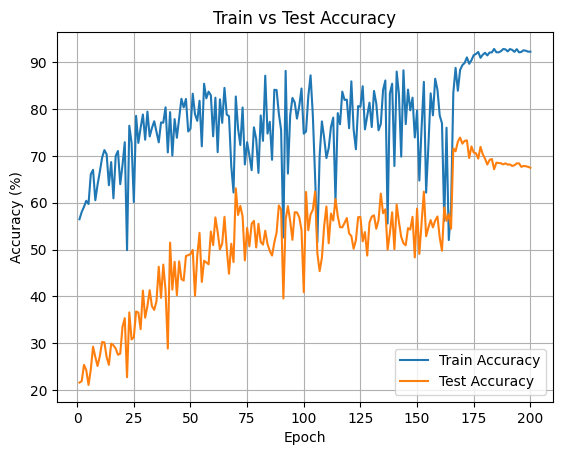

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load accuracy data
train_acc = np.load("/content/train_acc_history.npy")
test_acc = np.load("/content/test_acc_history.npy")

# Plot
epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import torch
import numpy as np


# --- Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "resnet32_elf_ldam_final.pth" # Your saved model file

# --- Load Model ---
model = ResNet32_ELF_model().to(device)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

# --- Load Test Data ---
_, test_loader, _ = get_cifar10_lt_32x32_loaders(imbalance_ratio=100)

# --- Search for the Best Inference Threshold ---
print("Starting inference threshold search...")

# The paper suggests searching over a range of thresholds
thresholds_to_test = np.arange(0.1, 1.0, 0.05)
best_accuracy = 0
best_threshold = 0

for threshold in thresholds_to_test:
    # Use the compute_accuracy function from your training script
    current_accuracy = compute_accuracy(model, test_loader, device, inference_threshold=threshold)

    print(f"Threshold: {threshold:.2f} -> Test Accuracy: {current_accuracy:.2f}%")

    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        best_threshold = threshold

print("\n" + "="*40)
print(f"Search Complete!")
print(f"Best Test Accuracy: {best_accuracy:.2f}% (found at threshold = {best_threshold:.2f})")
print("="*40)

Starting inference threshold search...
Threshold: 0.10 -> Test Accuracy: 65.40%
Threshold: 0.15 -> Test Accuracy: 67.07%
Threshold: 0.20 -> Test Accuracy: 71.90%
Threshold: 0.25 -> Test Accuracy: 72.29%
Threshold: 0.30 -> Test Accuracy: 71.07%
Threshold: 0.35 -> Test Accuracy: 69.70%
Threshold: 0.40 -> Test Accuracy: 68.60%
Threshold: 0.45 -> Test Accuracy: 67.84%
Threshold: 0.50 -> Test Accuracy: 67.46%
Threshold: 0.55 -> Test Accuracy: 67.24%
Threshold: 0.60 -> Test Accuracy: 67.05%
Threshold: 0.65 -> Test Accuracy: 66.90%
Threshold: 0.70 -> Test Accuracy: 66.85%
Threshold: 0.75 -> Test Accuracy: 66.82%
Threshold: 0.80 -> Test Accuracy: 66.82%
Threshold: 0.85 -> Test Accuracy: 66.81%
Threshold: 0.90 -> Test Accuracy: 66.81%
Threshold: 0.95 -> Test Accuracy: 66.81%

Search Complete!
Best Test Accuracy: 72.29% (found at threshold = 0.25)


# 50x

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import time

# ================== LDAM Loss (with per-sample reduction) ==================
class LDAMLoss(nn.Module):
    def __init__(self, class_counts, max_m=0.5, weight=None, s=30):
        super(LDAMLoss, self).__init__()
        margins = 1.0 / np.power(class_counts, 0.25)
        self.margins = torch.tensor(margins * (max_m / np.max(margins)), dtype=torch.float)
        self.weight = weight
        self.s = s

    def forward(self, logits, labels):
        if logits.device != self.margins.device:
            self.margins = self.margins.to(logits.device)
        if self.weight is not None and self.weight.device != logits.device:
            self.weight = self.weight.to(logits.device)

        index = torch.zeros_like(logits, dtype=torch.bool)
        index.scatter_(1, labels.data.view(-1, 1), 1)

        margin_adjusted_logits = logits - self.margins[labels].unsqueeze(1) * index.float()
        return F.cross_entropy(self.s * margin_adjusted_logits, labels, weight=self.weight, reduction='none')

# ================== DRW (Delayed Reweighting) ==================
def get_drw_weights(epoch, class_counts, drw_start_epoch, beta=0.9999):
    if epoch < drw_start_epoch:
        return None

    effective_num = 1.0 - np.power(beta, class_counts)
    weights = (1.0 - beta) / effective_num
    weights = weights / np.sum(weights) * len(class_counts)
    return torch.tensor(weights, dtype=torch.float)

# ================== ELF Loss Aggregation (Corrected Logic) ==================
def compute_elf_loss_per_batch(outputs, labels, criterion, threshold):
    batch_size = labels.size(0)
    per_sample_accumulated_loss = torch.zeros(batch_size, device=labels.device)
    has_exited = torch.zeros(batch_size, dtype=torch.bool, device=labels.device)

    for k, out_k in enumerate(outputs):
        loss_at_current_exit = criterion(out_k, labels)
        per_sample_accumulated_loss += loss_at_current_exit * (~has_exited).float()

        probs_k = F.softmax(out_k, dim=1)
        confs_k, preds_k = torch.max(probs_k, dim=1)
        current_exit_condition_met = (preds_k == labels) & (confs_k > threshold)
        has_exited = has_exited | current_exit_condition_met

        if has_exited.all():
            break

    return per_sample_accumulated_loss.mean()

# ================== Accuracy Computation (Inference-time Exiting) ==================
def compute_accuracy(model, dataloader, device, inference_threshold):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, confidences = model(inputs, exit_threshold=None, is_training=False)

            for i in range(inputs.size(0)):
                pred_made = False
                for exit_idx in range(len(outputs)):
                    if confidences[exit_idx][i] > inference_threshold:
                        sample_pred = torch.argmax(outputs[exit_idx][i])
                        pred_made = True
                        break

                if not pred_made:
                    sample_pred = torch.argmax(outputs[-1][i])

                if sample_pred == labels[i]:
                    correct += 1
                total += 1
    return 100. * correct / total

# ================================== Main Training Script ==================================

# --- Hyperparameters ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet32_ELF_model().to(device)

# --- Optimizer and Scheduler ---
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=2e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[160, 180], gamma=0.1)

# --- Training Configuration ---
num_epochs = 200
warmup_epochs_lr = 5
drw_start_epoch = 160
elf_training_threshold = 0.2
elf_inference_threshold = 0.5 # Placeholder for evaluation during training

# Initialize lists to store accuracy history
train_acc_history, test_acc_history = [], []

base_lr = 0.1

# --- Training Loop ---
print("\nStarting training with corrected DRW schedule...")
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()

    # Corrected Learning Rate Warmup
    if epoch < warmup_epochs_lr:
        current_lr = base_lr * (epoch + 1) / warmup_epochs_lr
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr
    else:
        current_lr = scheduler.get_last_lr()[0]

    drw_weights = get_drw_weights(epoch, class_counts, drw_start_epoch=drw_start_epoch)
    criterion = LDAMLoss(class_counts, max_m=0.5, weight=drw_weights, s=30).to(device)

    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, _ = model(inputs, is_training=True)
        loss = compute_elf_loss_per_batch(outputs, labels, criterion, threshold=elf_training_threshold)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        total_loss += loss.item()

    # Step scheduler only after warmup phase
    if epoch >= warmup_epochs_lr:
        scheduler.step()

    # --- Evaluation ---
    train_acc = compute_accuracy(model, train_loader, device, inference_threshold=elf_inference_threshold)
    test_acc = compute_accuracy(model, test_loader, device, inference_threshold=elf_inference_threshold)

    # Append results to history lists
    train_acc_history.append(train_acc)
    test_acc_history.append(test_acc)

    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1:03d} | Time: {epoch_time:.1f}s | LR: {current_lr:.5f} | "
          f"Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}% | Loss: {total_loss/len(train_loader):.4f}")

print("\nTraining complete.")

# Save the model and accuracy history
print("Saving artifacts...")
np.save("train_acc_history.npy", np.array(train_acc_history))
np.save("test_acc_history.npy", np.array(test_acc_history))
torch.save(model.state_dict(), "resnet32_elf_ldam_final.pth")
print("Artifacts saved successfully!")


Starting training with corrected DRW schedule...
Epoch 001 | Time: 27.1s | LR: 0.02000 | Train Acc: 51.74% | Test Acc: 19.64% | Loss: 35.6468
Epoch 002 | Time: 24.1s | LR: 0.04000 | Train Acc: 46.36% | Test Acc: 22.48% | Loss: 33.3161
Epoch 003 | Time: 23.4s | LR: 0.06000 | Train Acc: 40.86% | Test Acc: 21.95% | Loss: 30.2116
Epoch 004 | Time: 23.7s | LR: 0.08000 | Train Acc: 54.83% | Test Acc: 26.10% | Loss: 30.1626
Epoch 005 | Time: 23.6s | LR: 0.10000 | Train Acc: 58.23% | Test Acc: 26.71% | Loss: 31.8475
Epoch 006 | Time: 23.5s | LR: 0.10000 | Train Acc: 46.18% | Test Acc: 22.48% | Loss: 28.9897
Epoch 007 | Time: 23.7s | LR: 0.10000 | Train Acc: 45.19% | Test Acc: 21.75% | Loss: 28.8556
Epoch 008 | Time: 23.8s | LR: 0.10000 | Train Acc: 43.95% | Test Acc: 16.56% | Loss: 28.4162
Epoch 009 | Time: 23.8s | LR: 0.10000 | Train Acc: 60.50% | Test Acc: 29.63% | Loss: 27.1076
Epoch 010 | Time: 24.2s | LR: 0.10000 | Train Acc: 61.53% | Test Acc: 29.43% | Loss: 27.1925
Epoch 011 | Time: 23

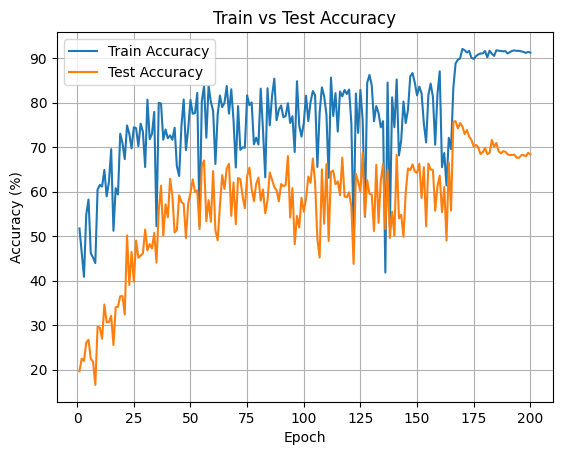

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load accuracy data
train_acc = np.load("/content/train_acc_history.npy")
test_acc = np.load("/content/test_acc_history.npy")

# Plot
epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import torch
import numpy as np

# --- Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "resnet32_elf_ldam_final.pth" # Your saved model file

# --- Load Model ---
model = ResNet32_ELF_model().to(device)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

# --- Load Test Data ---
_, test_loader, _ = get_cifar10_lt_32x32_loaders(imbalance_ratio=100)

# --- Search for the Best Inference Threshold ---
print("Starting inference threshold search...")

# The paper suggests searching over a range of thresholds
thresholds_to_test = np.arange(0.1, 1.0, 0.05)
best_accuracy = 0
best_threshold = 0

for threshold in thresholds_to_test:
    # Use the compute_accuracy function from your training script
    current_accuracy = compute_accuracy(model, test_loader, device, inference_threshold=threshold)

    print(f"Threshold: {threshold:.2f} -> Test Accuracy: {current_accuracy:.2f}%")

    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        best_threshold = threshold

print("\n" + "="*40)
print(f"Search Complete!")
print(f"Best Test Accuracy: {best_accuracy:.2f}% (found at threshold = {best_threshold:.2f})")
print("="*40)

Starting inference threshold search...
Threshold: 0.10 -> Test Accuracy: 69.19%
Threshold: 0.15 -> Test Accuracy: 70.37%
Threshold: 0.20 -> Test Accuracy: 75.19%
Threshold: 0.25 -> Test Accuracy: 76.74%
Threshold: 0.30 -> Test Accuracy: 74.76%
Threshold: 0.35 -> Test Accuracy: 73.11%
Threshold: 0.40 -> Test Accuracy: 71.29%
Threshold: 0.45 -> Test Accuracy: 69.64%
Threshold: 0.50 -> Test Accuracy: 68.37%
Threshold: 0.55 -> Test Accuracy: 67.31%
Threshold: 0.60 -> Test Accuracy: 66.76%
Threshold: 0.65 -> Test Accuracy: 66.35%
Threshold: 0.70 -> Test Accuracy: 66.10%
Threshold: 0.75 -> Test Accuracy: 65.93%
Threshold: 0.80 -> Test Accuracy: 65.82%
Threshold: 0.85 -> Test Accuracy: 65.78%
Threshold: 0.90 -> Test Accuracy: 65.77%
Threshold: 0.95 -> Test Accuracy: 65.77%

Search Complete!
Best Test Accuracy: 76.74% (found at threshold = 0.25)


# 10x

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import time

# ================== LDAM Loss (with per-sample reduction) ==================
class LDAMLoss(nn.Module):
    def __init__(self, class_counts, max_m=0.5, weight=None, s=30):
        super(LDAMLoss, self).__init__()
        margins = 1.0 / np.power(class_counts, 0.25)
        self.margins = torch.tensor(margins * (max_m / np.max(margins)), dtype=torch.float)
        self.weight = weight
        self.s = s

    def forward(self, logits, labels):
        if logits.device != self.margins.device:
            self.margins = self.margins.to(logits.device)
        if self.weight is not None and self.weight.device != logits.device:
            self.weight = self.weight.to(logits.device)

        index = torch.zeros_like(logits, dtype=torch.bool)
        index.scatter_(1, labels.data.view(-1, 1), 1)

        margin_adjusted_logits = logits - self.margins[labels].unsqueeze(1) * index.float()
        return F.cross_entropy(self.s * margin_adjusted_logits, labels, weight=self.weight, reduction='none')

# ================== DRW (Delayed Reweighting) ==================
def get_drw_weights(epoch, class_counts, drw_start_epoch, beta=0.9999):
    if epoch < drw_start_epoch:
        return None

    effective_num = 1.0 - np.power(beta, class_counts)
    weights = (1.0 - beta) / effective_num
    weights = weights / np.sum(weights) * len(class_counts)
    return torch.tensor(weights, dtype=torch.float)

# ================== ELF Loss Aggregation (Corrected Logic) ==================
def compute_elf_loss_per_batch(outputs, labels, criterion, threshold):
    batch_size = labels.size(0)
    per_sample_accumulated_loss = torch.zeros(batch_size, device=labels.device)
    has_exited = torch.zeros(batch_size, dtype=torch.bool, device=labels.device)

    for k, out_k in enumerate(outputs):
        loss_at_current_exit = criterion(out_k, labels)
        per_sample_accumulated_loss += loss_at_current_exit * (~has_exited).float()

        probs_k = F.softmax(out_k, dim=1)
        confs_k, preds_k = torch.max(probs_k, dim=1)
        current_exit_condition_met = (preds_k == labels) & (confs_k > threshold)
        has_exited = has_exited | current_exit_condition_met

        if has_exited.all():
            break

    return per_sample_accumulated_loss.mean()

# ================== Accuracy Computation (Inference-time Exiting) ==================
def compute_accuracy(model, dataloader, device, inference_threshold):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, confidences = model(inputs, exit_threshold=None, is_training=False)

            for i in range(inputs.size(0)):
                pred_made = False
                for exit_idx in range(len(outputs)):
                    if confidences[exit_idx][i] > inference_threshold:
                        sample_pred = torch.argmax(outputs[exit_idx][i])
                        pred_made = True
                        break

                if not pred_made:
                    sample_pred = torch.argmax(outputs[-1][i])

                if sample_pred == labels[i]:
                    correct += 1
                total += 1
    return 100. * correct / total

# ================================== Main Training Script ==================================

# --- Hyperparameters ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet32_ELF_model().to(device)

# --- Optimizer and Scheduler ---
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=2e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[160, 180], gamma=0.1)

# --- Training Configuration ---
num_epochs = 200
warmup_epochs_lr = 5
drw_start_epoch = 160
elf_training_threshold = 0.2
elf_inference_threshold = 0.5 # Placeholder for evaluation during training

# Initialize lists to store accuracy history
train_acc_history, test_acc_history = [], []

base_lr = 0.1

# --- Training Loop ---
print("\nStarting training with corrected DRW schedule...")
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()

    # Corrected Learning Rate Warmup
    if epoch < warmup_epochs_lr:
        current_lr = base_lr * (epoch + 1) / warmup_epochs_lr
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr
    else:
        current_lr = scheduler.get_last_lr()[0]

    drw_weights = get_drw_weights(epoch, class_counts, drw_start_epoch=drw_start_epoch)
    criterion = LDAMLoss(class_counts, max_m=0.5, weight=drw_weights, s=30).to(device)

    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, _ = model(inputs, is_training=True)
        loss = compute_elf_loss_per_batch(outputs, labels, criterion, threshold=elf_training_threshold)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        total_loss += loss.item()

    # Step scheduler only after warmup phase
    if epoch >= warmup_epochs_lr:
        scheduler.step()

    # --- Evaluation ---
    train_acc = compute_accuracy(model, train_loader, device, inference_threshold=elf_inference_threshold)
    test_acc = compute_accuracy(model, test_loader, device, inference_threshold=elf_inference_threshold)

    # Append results to history lists
    train_acc_history.append(train_acc)
    test_acc_history.append(test_acc)

    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1:03d} | Time: {epoch_time:.1f}s | LR: {current_lr:.5f} | "
          f"Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}% | Loss: {total_loss/len(train_loader):.4f}")

print("\nTraining complete.")

# Save the model and accuracy history
print("Saving artifacts...")
np.save("train_acc_history.npy", np.array(train_acc_history))
np.save("test_acc_history.npy", np.array(test_acc_history))
torch.save(model.state_dict(), "resnet32_elf_ldam_final.pth")
print("Artifacts saved successfully!")


Starting training with corrected DRW schedule...
Epoch 001 | Time: 34.2s | LR: 0.02000 | Train Acc: 40.43% | Test Acc: 22.99% | Loss: 48.4589
Epoch 002 | Time: 31.6s | LR: 0.04000 | Train Acc: 40.72% | Test Acc: 23.82% | Loss: 45.1181
Epoch 003 | Time: 31.7s | LR: 0.06000 | Train Acc: 45.91% | Test Acc: 27.62% | Loss: 42.8932
Epoch 004 | Time: 31.1s | LR: 0.08000 | Train Acc: 47.48% | Test Acc: 30.86% | Loss: 43.2716
Epoch 005 | Time: 31.8s | LR: 0.10000 | Train Acc: 49.30% | Test Acc: 29.90% | Loss: 43.7785
Epoch 006 | Time: 31.1s | LR: 0.10000 | Train Acc: 50.46% | Test Acc: 32.22% | Loss: 43.5046
Epoch 007 | Time: 31.8s | LR: 0.10000 | Train Acc: 47.07% | Test Acc: 35.93% | Loss: 42.0373
Epoch 008 | Time: 31.0s | LR: 0.10000 | Train Acc: 53.66% | Test Acc: 35.91% | Loss: 40.5693
Epoch 009 | Time: 31.8s | LR: 0.10000 | Train Acc: 46.84% | Test Acc: 35.98% | Loss: 40.3815
Epoch 010 | Time: 31.0s | LR: 0.10000 | Train Acc: 51.20% | Test Acc: 41.52% | Loss: 39.9556
Epoch 011 | Time: 31

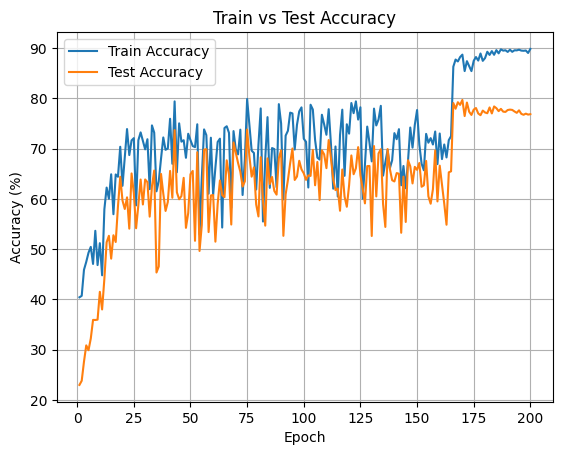

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load accuracy data
train_acc = np.load("/content/train_acc_history.npy")
test_acc = np.load("/content/test_acc_history.npy")

# Plot
epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import torch
import numpy as np

# --- Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "resnet32_elf_ldam_final.pth" # Your saved model file

# --- Load Model ---
model = ResNet32_ELF_model().to(device)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

# --- Load Test Data ---
_, test_loader, _ = get_cifar10_lt_32x32_loaders(imbalance_ratio=100)

# --- Search for the Best Inference Threshold ---
print("Starting inference threshold search...")

# The paper suggests searching over a range of thresholds
thresholds_to_test = np.arange(0.1, 1.0, 0.05)
best_accuracy = 0
best_threshold = 0

for threshold in thresholds_to_test:
    # Use the compute_accuracy function from your training script
    current_accuracy = compute_accuracy(model, test_loader, device, inference_threshold=threshold)

    print(f"Threshold: {threshold:.2f} -> Test Accuracy: {current_accuracy:.2f}%")

    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        best_threshold = threshold

print("\n" + "="*40)
print(f"Search Complete!")
print(f"Best Test Accuracy: {best_accuracy:.2f}% (found at threshold = {best_threshold:.2f})")
print("="*40)

Starting inference threshold search...
Threshold: 0.10 -> Test Accuracy: 76.99%
Threshold: 0.15 -> Test Accuracy: 77.35%
Threshold: 0.20 -> Test Accuracy: 80.29%
Threshold: 0.25 -> Test Accuracy: 82.58%
Threshold: 0.30 -> Test Accuracy: 82.67%
Threshold: 0.35 -> Test Accuracy: 81.63%
Threshold: 0.40 -> Test Accuracy: 79.93%
Threshold: 0.45 -> Test Accuracy: 78.36%
Threshold: 0.50 -> Test Accuracy: 76.87%
Threshold: 0.55 -> Test Accuracy: 75.66%
Threshold: 0.60 -> Test Accuracy: 74.55%
Threshold: 0.65 -> Test Accuracy: 73.80%
Threshold: 0.70 -> Test Accuracy: 73.16%
Threshold: 0.75 -> Test Accuracy: 72.62%
Threshold: 0.80 -> Test Accuracy: 72.20%
Threshold: 0.85 -> Test Accuracy: 71.84%
Threshold: 0.90 -> Test Accuracy: 71.60%
Threshold: 0.95 -> Test Accuracy: 71.49%

Search Complete!
Best Test Accuracy: 82.67% (found at threshold = 0.30)
